<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/1IMRxByfg7gjoZ5i7rxvuNDvSrbdOJOc-/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

In [1]:
# импортируем нужное и не очень
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import get_scheduler
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer, BertModel
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import f1_score, accuracy_score
from torch.optim import AdamW
from torch.optim import lr_scheduler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
data_problems = pd.read_excel("data_problems.xlsx")

data = data_problems.drop("Unnamed: 0", axis=1) # убираем лишний столбец
data = data.drop_duplicates(subset='Задача') # убираем дубли
data = data[data["Задача"].str.len() > 10] # убираем всё до 10 символов
sample_1 =  data.loc[111] # тестовый пример
sample_2 =  data.loc[1111]

train_data, val_data = train_test_split(data, test_size=0.35, stratify=data["Тема"], shuffle=True, random_state=42) # делим 65 на 35

In [3]:
print(sample_1["Задача"])

Есть  волейбольная  сетка 5×10. Какое максимальное число веревок, её составляющих, можно разрезать так, чтобы она  не распалась? 


In [4]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.classes = [class_ for class_ in dataframe['Тема'].unique() if class_]
        self.class2id = {class_:id for id, class_ in enumerate(self.classes)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.loc[idx, 'Задача']
        label = self.dataframe.loc[idx, 'Тема']
        label = self.class2id[label]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=512, 
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [5]:
def collate_fn(batch):
    input_ids = torch.stack([b['input_ids'] for b in batch], dim=0)
    attention_mask = torch.stack([b['attention_mask'] for b in batch], dim=0)
    labels = torch.stack([b['labels'] for b in batch], dim=0)
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [6]:
### This is just an interface example. You may change it if you want.
from typing import Union

class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module], num_classes: int):
        super(TransformerClassificationModel, self).__init__()
        self.backbone = AutoModel.from_pretrained(base_transformer_model)
        self.classifier = nn.Linear(self.backbone.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, return_attention=False):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask, output_attentions=return_attention)
        logits = self.classifier(outputs.last_hidden_state[:, 0, :])
        if return_attention:
            return {'logits': logits, 'attentions': outputs.attentions}
        else:
            return {'logits': logits}

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [7]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [8]:
# копи работает странно и почему-то обучало мне исходную модель. Так что просто наштампую потом инстансов класса
def inference(model): # я думал, что пригодится инференс отдельно, но не пригодился. А доп вызов функции слегка замедляет, но переделывать уже лень
    model.eval()
    epoch_val_loss = 0.0
    epoch_val_acc = 0.0
    epoch_val_f1 = 0.0
    with torch.no_grad():
        for batch in val_data_loader:
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(inputs, attention_mask)
            logits = outputs['logits']
            loss = nn.CrossEntropyLoss()(logits, labels)
            epoch_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            epoch_val_acc += accuracy_score(labels.cpu(), preds.cpu())
            epoch_val_f1 += f1_score(labels.cpu(), preds.cpu(), average='macro')
    return (epoch_val_loss, epoch_val_acc, epoch_val_f1)

def train_transformer(model, freeze_backbone=True, epochs=10, learning_rate=3e-4):
    if freeze_backbone:
        freeze_backbone_function(model)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_data_loader) * epochs
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    train_losses = []
    train_accs = []
    train_f1s = []
    val_losses = []
    val_accs = []
    val_f1s = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        epoch_train_f1 = 0.0
        for batch in train_data_loader:
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs, attention_mask)
            logits = outputs['logits']
            loss = nn.CrossEntropyLoss()(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_train_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            epoch_train_acc += accuracy_score(labels.cpu(), preds.cpu())
            epoch_train_f1 += f1_score(labels.cpu(), preds.cpu(), average='macro')

        epoch_val_loss, epoch_val_acc, epoch_val_f1 = inference(model)

        train_losses.append(epoch_train_loss / len(train_data_loader))
        train_accs.append(epoch_train_acc / len(train_data_loader))
        train_f1s.append(epoch_train_f1 / len(train_data_loader))
        val_losses.append(epoch_val_loss / len(val_data_loader))
        val_accs.append(epoch_val_acc / len(val_data_loader))
        val_f1s.append(epoch_val_f1 / len(val_data_loader))

    return train_losses, train_accs, train_f1s, val_losses, val_accs, val_f1s

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [9]:
num_classes = len(data["Тема"].unique()) # количество классов для построение линейного слоя
# недостающая предобработочка датасета
train_data.reset_index(drop=True, inplace=True) 
val_data.reset_index(drop=True, inplace=True)

In [10]:
rubert_tiny_transformer_model = "cointegrated/rubert-tiny2"
rubert_tiny = TransformerClassificationModel(rubert_tiny_transformer_model, num_classes)

tokenizer_rubert = AutoTokenizer.from_pretrained(rubert_tiny_transformer_model)

train_dataset = CustomDataset(train_data, tokenizer_rubert)
val_dataset = CustomDataset(val_data, tokenizer_rubert)

train_data_loader = DataLoader(train_dataset, batch_size=16, collate_fn=collate_fn, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_fn, shuffle=True)

rubert_ft_fb = TransformerClassificationModel(rubert_tiny_transformer_model, num_classes)
rb_ft_fb_train_losses, rb_ft_fb_train_accs, rb_ft_fb_train_f1s, rb_ft_fb_val_losses, rb_ft_fb_val_accs, rb_ft_fb_val_f1s = train_transformer(
    rubert_ft_fb, epochs=10, freeze_backbone=True)

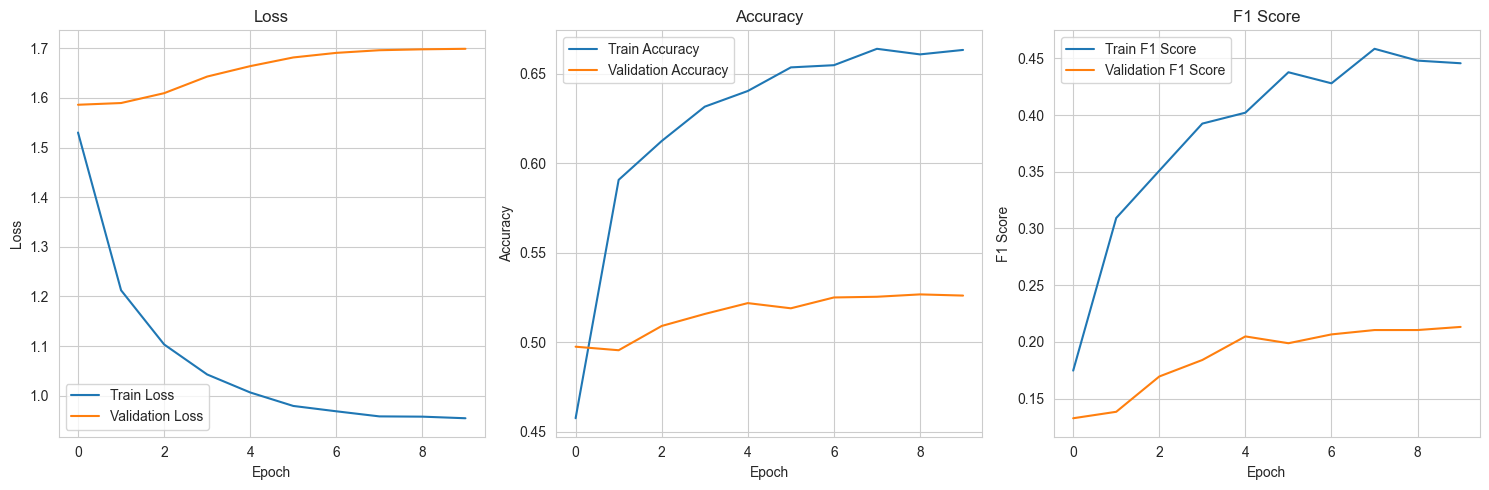

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

def plot_metrics(train_losses, train_accs, train_f1s, val_losses, val_accs, val_f1s):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 1 row and 3 columns

    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(train_accs, label='Train Accuracy')
    axs[1].plot(val_accs, label='Validation Accuracy')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    axs[2].plot(train_f1s, label='Train F1 Score')
    axs[2].plot(val_f1s, label='Validation F1 Score')
    axs[2].set_title('F1 Score')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('F1 Score')
    axs[2].legend()

    plt.tight_layout() 
    plt.show()

plot_metrics(rb_ft_fb_train_losses, rb_ft_fb_train_accs, rb_ft_fb_train_f1s, rb_ft_fb_val_losses, rb_ft_fb_val_accs, rb_ft_fb_val_f1s)

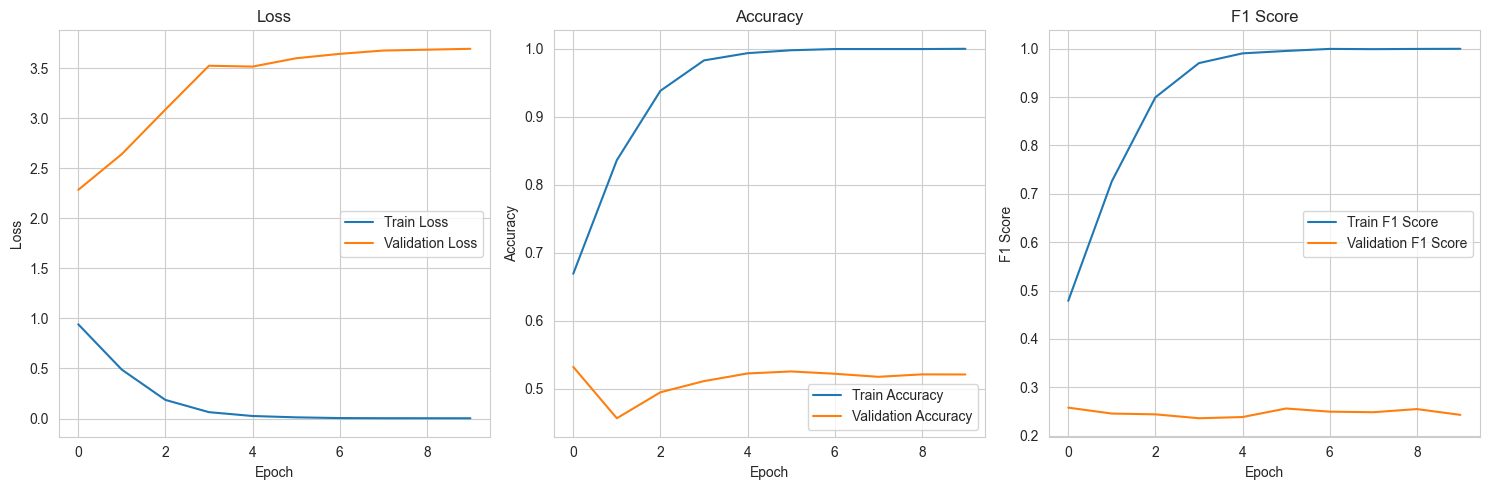

In [12]:
rubert_fft = TransformerClassificationModel(rubert_tiny_transformer_model, num_classes)
rb_fft_train_losses, rb_fft_train_accs, rb_fft_train_f1s, rb_fft_val_losses, rb_fft_val_accs, rb_fft_val_f1s = train_transformer(
    rubert_fft, epochs=10, freeze_backbone=False)

plot_metrics(rb_fft_train_losses, rb_fft_train_accs, rb_fft_train_f1s, rb_fft_val_losses, rb_fft_val_accs, rb_fft_val_f1s)

Видно, что при таком разбиении датасета с размороженными слоями модель начинает сильно перееобучаться под трейн. Точночть остаётся +/- одинаковой, а вот f1 с размороженными слоями заметно лучше

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

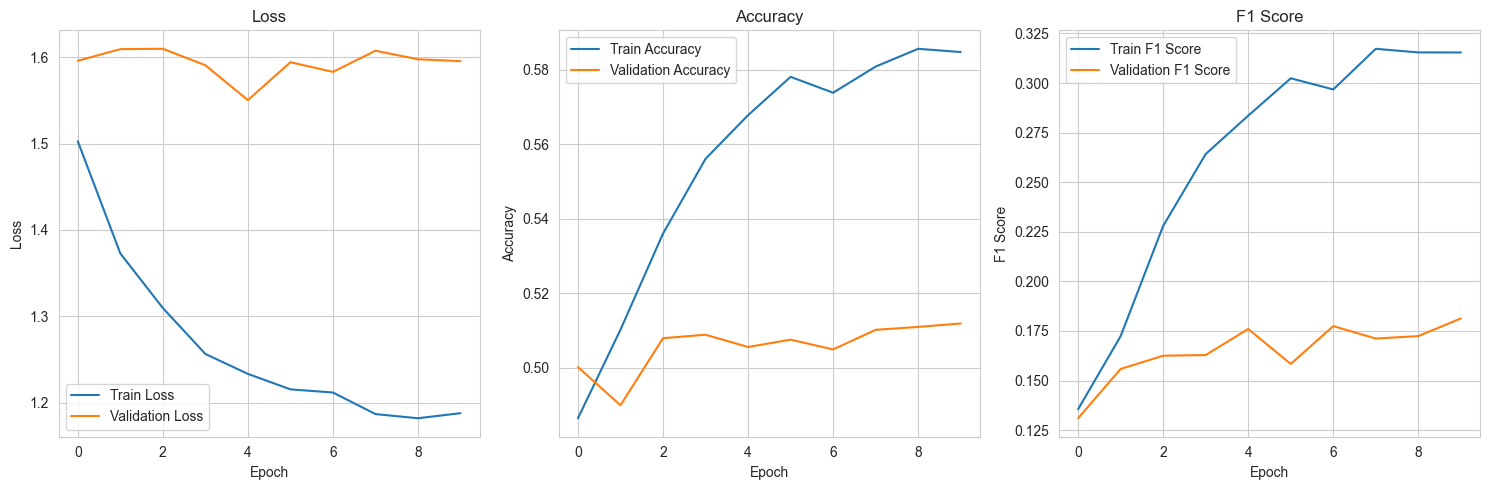

In [49]:
MathBert_transformer_model = "tbs17/MathBert"
MathBert = TransformerClassificationModel(MathBert_transformer_model, num_classes)

tokenizer_MathBert = AutoTokenizer.from_pretrained(MathBert_transformer_model)

train_dataset = CustomDataset(train_data, tokenizer_MathBert)
val_dataset = CustomDataset(val_data, tokenizer_MathBert)

train_data_loader = DataLoader(train_dataset, batch_size=16, collate_fn=collate_fn, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_fn, shuffle=True)

MathBert_ft_fb = TransformerClassificationModel(MathBert_transformer_model, num_classes)
MathBert_ft_fb_train_losses, MathBert_ft_fb_train_accs, MathBert_ft_fb_train_f1s, MathBert_ft_fb_val_losses, MathBert_ft_fb_val_accs, MathBert_ft_fb_val_f1s = train_transformer(
    MathBert, epochs=10, freeze_backbone=True)

plot_metrics(MathBert_ft_fb_train_losses, MathBert_ft_fb_train_accs, MathBert_ft_fb_train_f1s, MathBert_ft_fb_val_losses, MathBert_ft_fb_val_accs, MathBert_ft_fb_val_f1s)

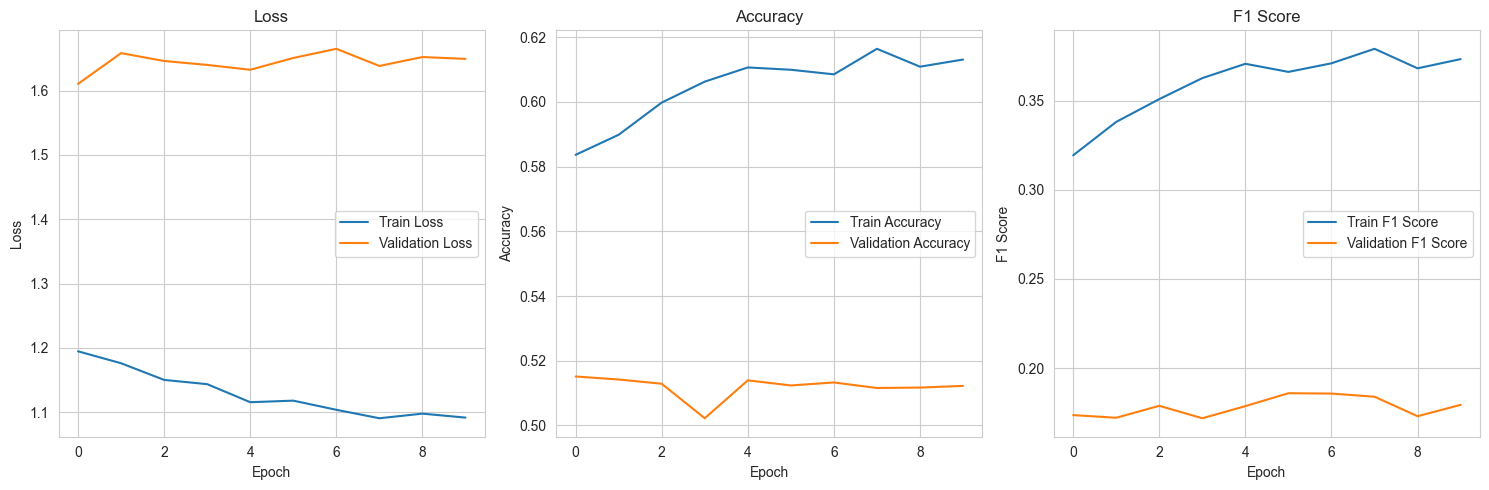

In [50]:
MathBert_fft = TransformerClassificationModel(MathBert_transformer_model, num_classes)
MathBert_fft_train_losses, MathBert_fft_train_accs, MathBert_fft_train_f1s, MathBert_fft_val_losses, MathBert_fft_val_accs, MathBert_fft_val_f1s = train_transformer(
    MathBert, epochs=10, freeze_backbone=False)
plot_metrics(MathBert_fft_train_losses, MathBert_fft_train_accs, MathBert_fft_train_f1s, MathBert_fft_val_losses, MathBert_fft_val_accs, MathBert_fft_val_f1s)

MathBert разбивает русский текст на минимальные токены длиной в букву. Поэтому переобучения на размороженных слоях мы не видим. Качество сходное с рубертом. Дообученные слои лучше чем замороженные

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [15]:
def plot_attention_head(sample, tokenizer, model, head_num, Ticks=True):
    inputs = tokenizer(sample["Задача"], return_tensors="pt").to(device)
    tokens = tokenizer.tokenize(sample["Задача"])
    ticks = [t.lower() for t in tokens]
    ticks.append("SEP")
    ticks.insert(0, "CLS")
    with torch.no_grad():
        outputs = model(inputs["input_ids"], inputs["attention_mask"], return_attention=True)
        attentions = outputs["attentions"][0]
    fig, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(attentions[0][head_num].cpu().numpy(), cmap="coolwarm")
    ax.set_title(f'Тепловая карта внимания для головы №{head_num+1}')
    if Ticks:
        ax.xaxis.set_ticklabels(ticks, rotation=90)
        ax.yaxis.set_ticklabels(ticks, rotation=0)
    plt.show()


### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

В связи с тем, что MathBert не дружит с русским языком, то токеном для него явлеятся не слово или его часть, а буква, что превращает интерпретацию карт вниманий в довольно бессмысленное занятие. Пример такой карты ниже. Поэтому интерпретировать будем только Руберта

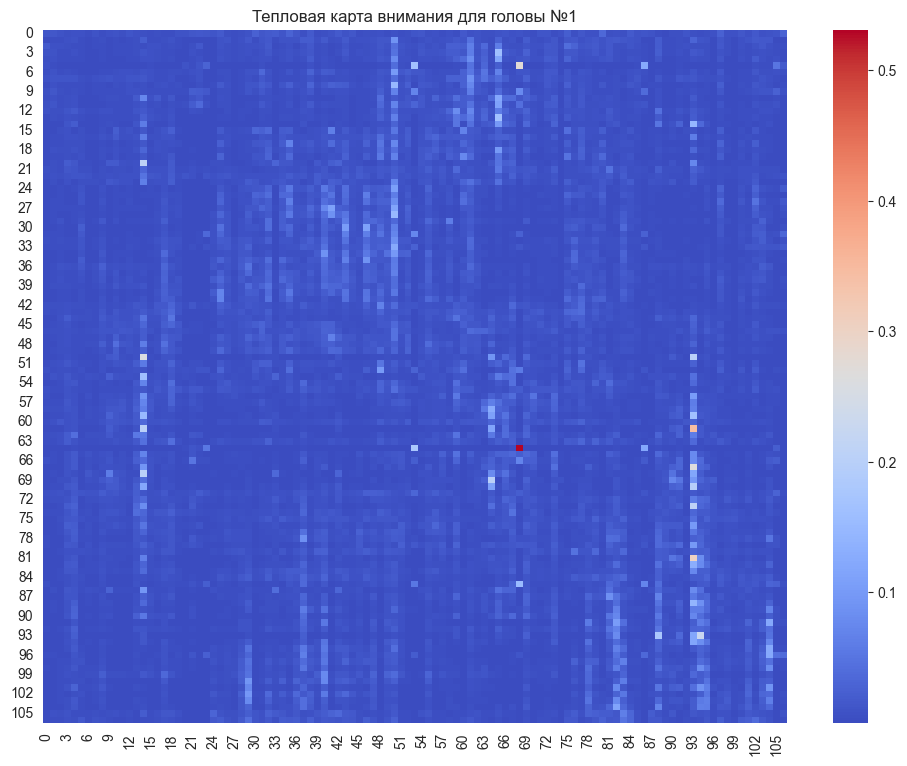

In [51]:
plot_attention_head(sample_1, tokenizer_MathBert, MathBert, 0, Ticks=False)

Руберт в первом слое имеет 12 голов внимания. Грубо, я их разделил на 4 категории:
- Внимание на само себя и ближайшие несколько токенов
- Распределённое внимание
- Ближние токены
- Специальные

Ну и в некотором роде некоторые головы можно отнести сразу к нескольким категориям

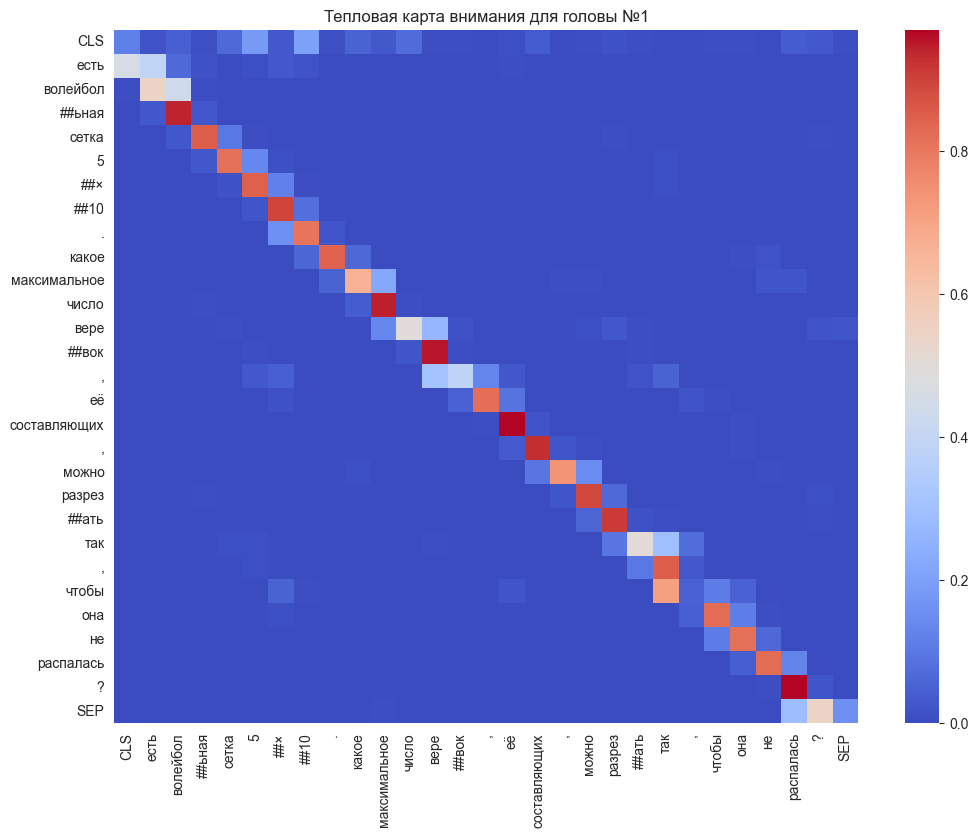

In [20]:
rubert_tiny.to(device)
plot_attention_head(sample_1, tokenizer_rubert, rubert_tiny, 0)

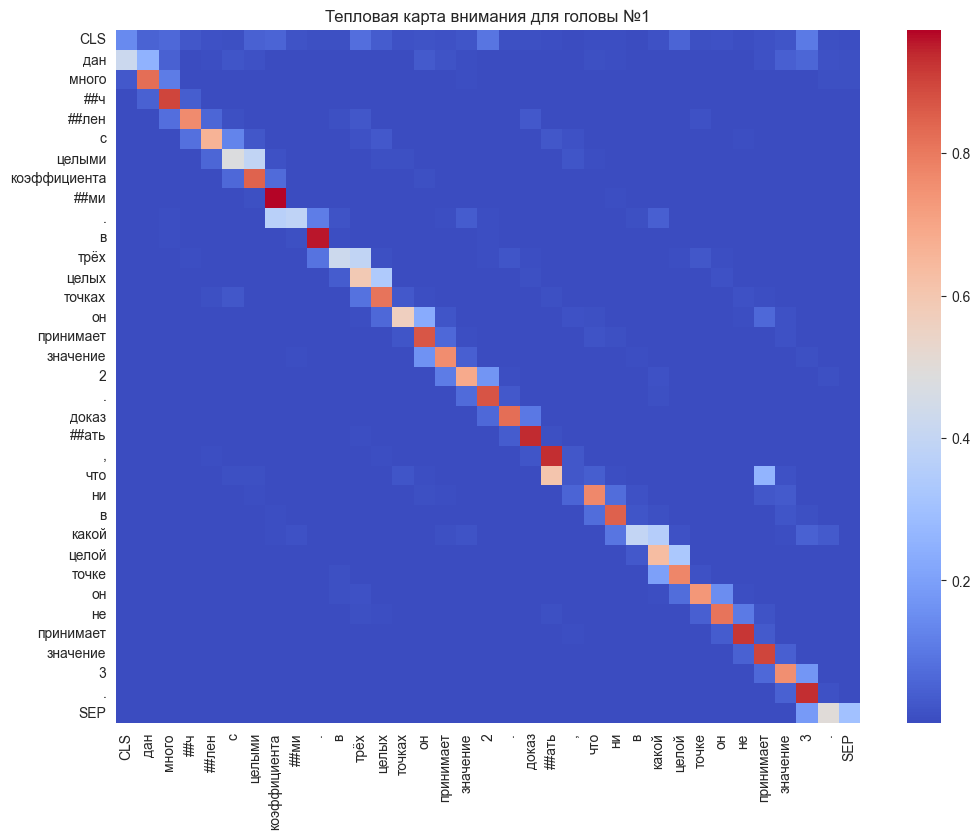

In [21]:
plot_attention_head(sample_2, tokenizer_rubert, rubert_tiny, 0)

Здесь видно, что внимание каждого токена сконцентрированно на в основном на самом себе и ближайших токенах. Иногда внимания удостаивается связанный по тексту токен. Например во втором примере токен "что" смотрит на токен "принимает". В контексте "доказать, ЧТО ни в какой целой точке он не ПРИНИМАЕТ значение 3" можно увидеть некоторую смысловую связь между этими словами.
Похоже на такое распределение внимания также имеют головы №2, 7

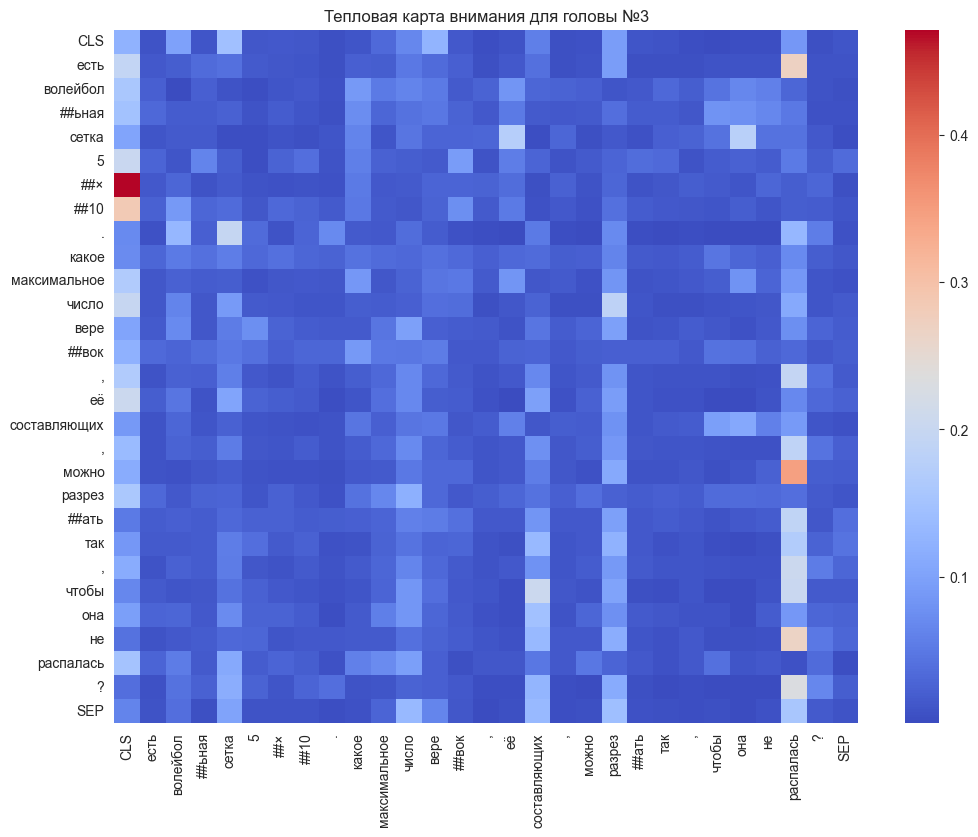

In [22]:
plot_attention_head(sample_1, tokenizer_rubert, rubert_tiny, 2)

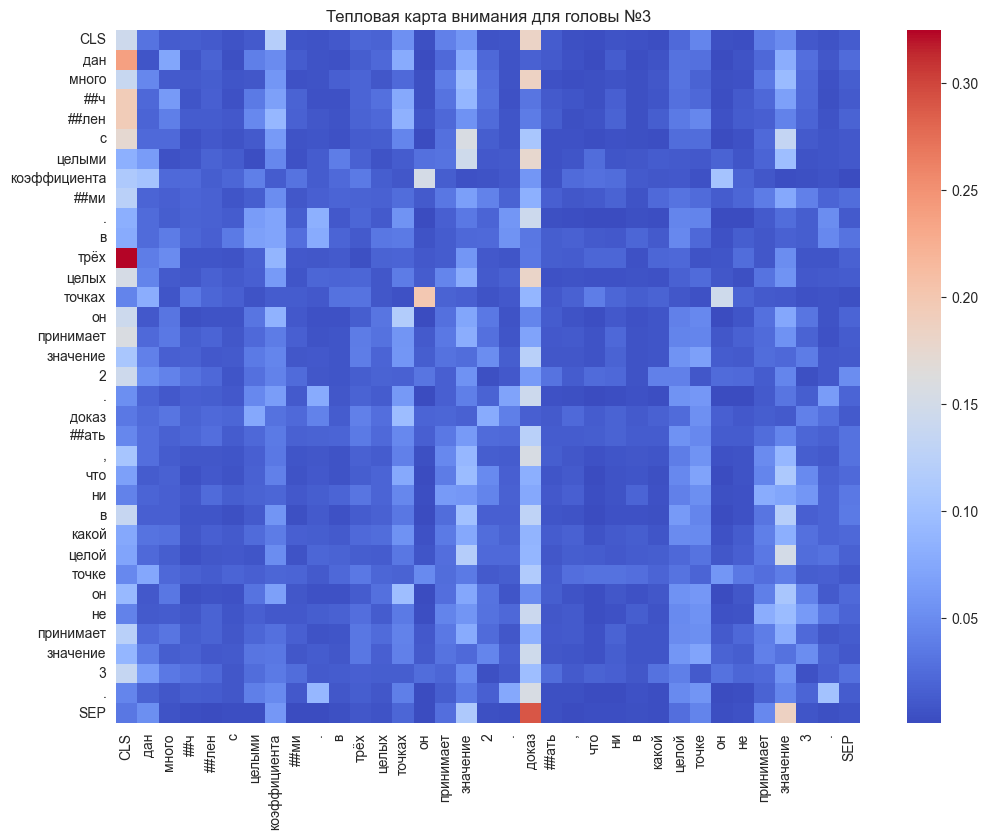

In [23]:
plot_attention_head(sample_2, tokenizer_rubert, rubert_tiny, 2)

Головы № 3, 4, 6, 11 по всей видимости ищут связи между токенами по всему тексту. За редким исключением они не концентриют внимание на конкретном токене

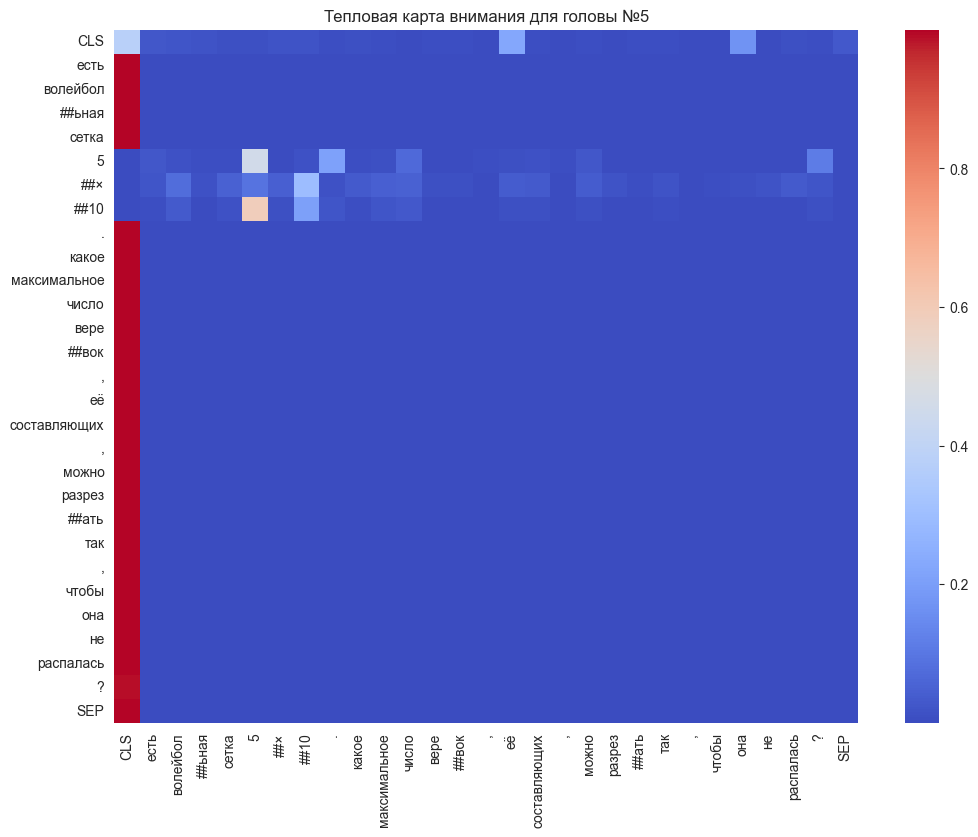

In [24]:
plot_attention_head(sample_1, tokenizer_rubert, rubert_tiny, 4)

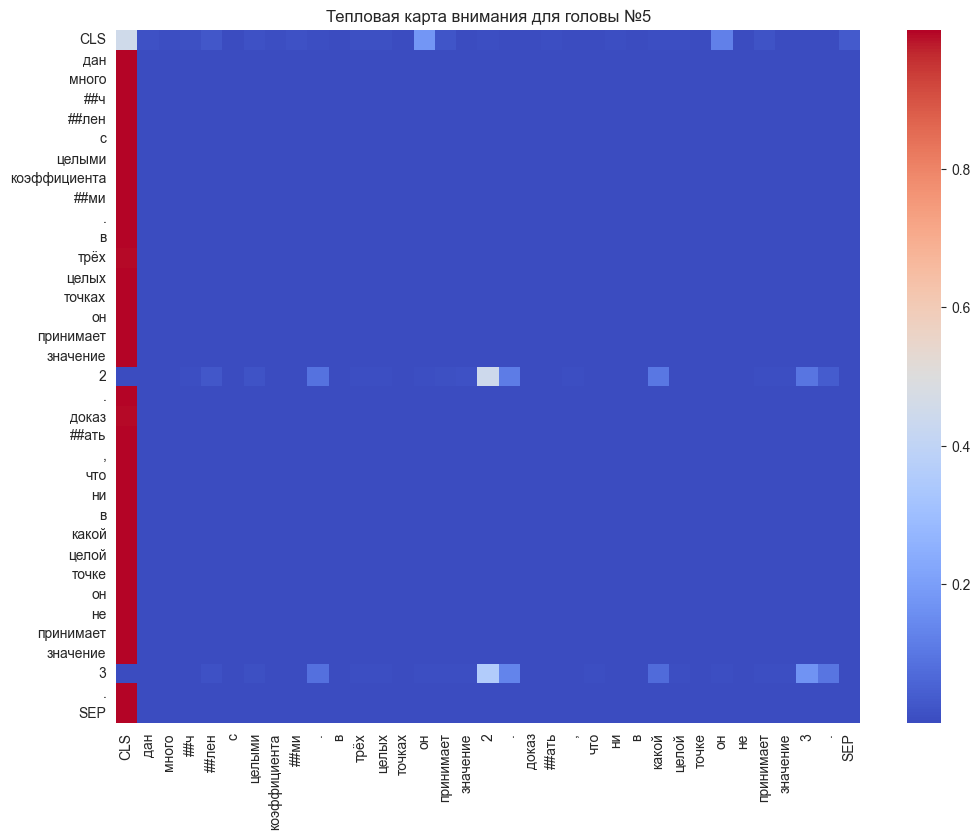

In [25]:
plot_attention_head(sample_2, tokenizer_rubert, rubert_tiny, 4)

Голова №5 явно служит для цифр.

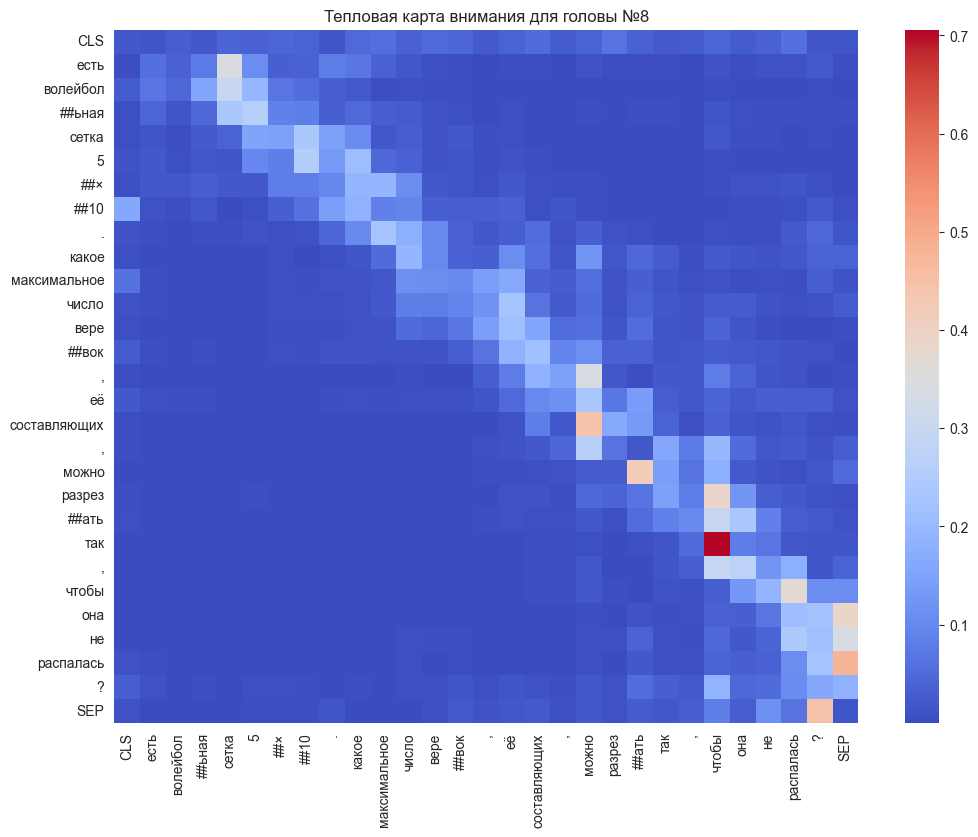

In [26]:
plot_attention_head(sample_1, tokenizer_rubert, rubert_tiny, 7)

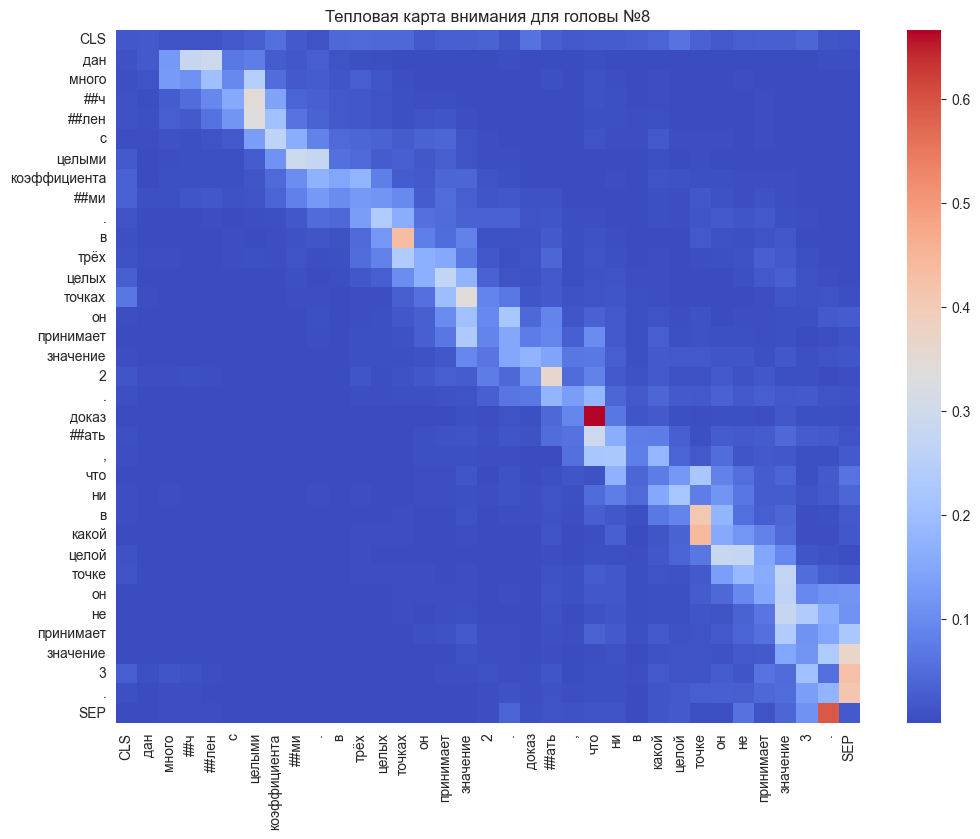

In [27]:
plot_attention_head(sample_2, tokenizer_rubert, rubert_tiny, 7)

Головы №8, 9, 10, 12 нечто среднее между перпвыми двумя видами голов. Они смотрят на соседей, но не самых ближайших. Так же явно для предлогов, союзов и прочего ищется "напарник". "Доказать что", "так чтобы" 

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

Тут для простоты будем пользоваться только sample_2 как чуть более репрезентативным

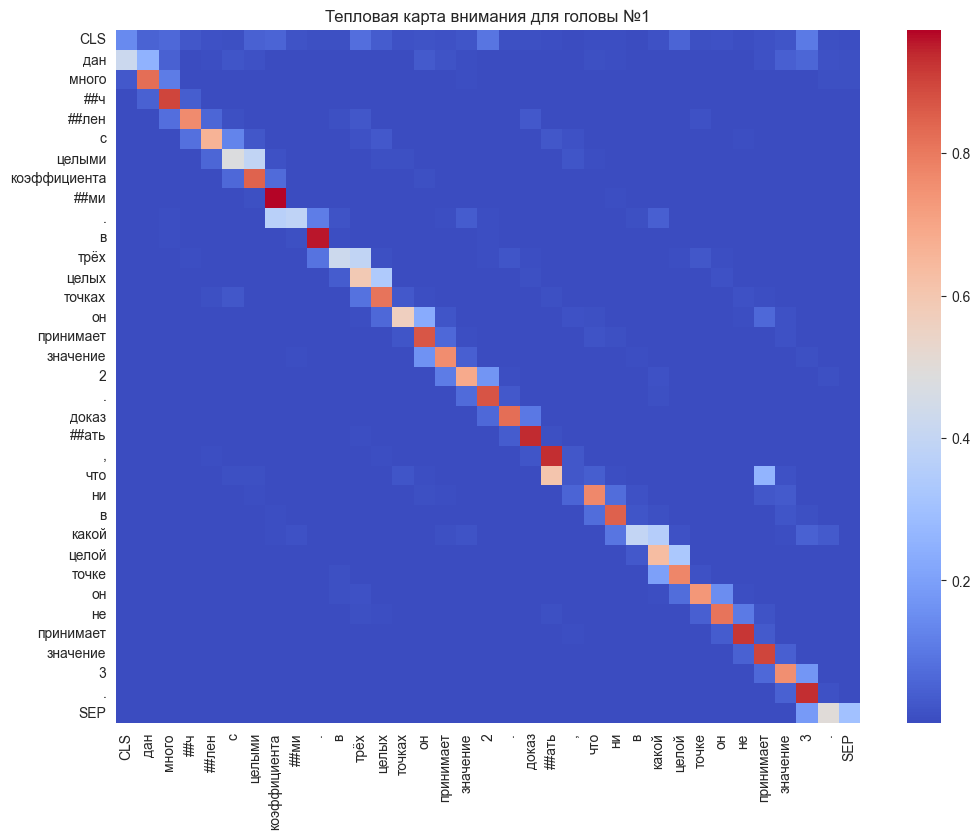

In [28]:
plot_attention_head(sample_2, tokenizer_rubert, rubert_ft_fb, 0)

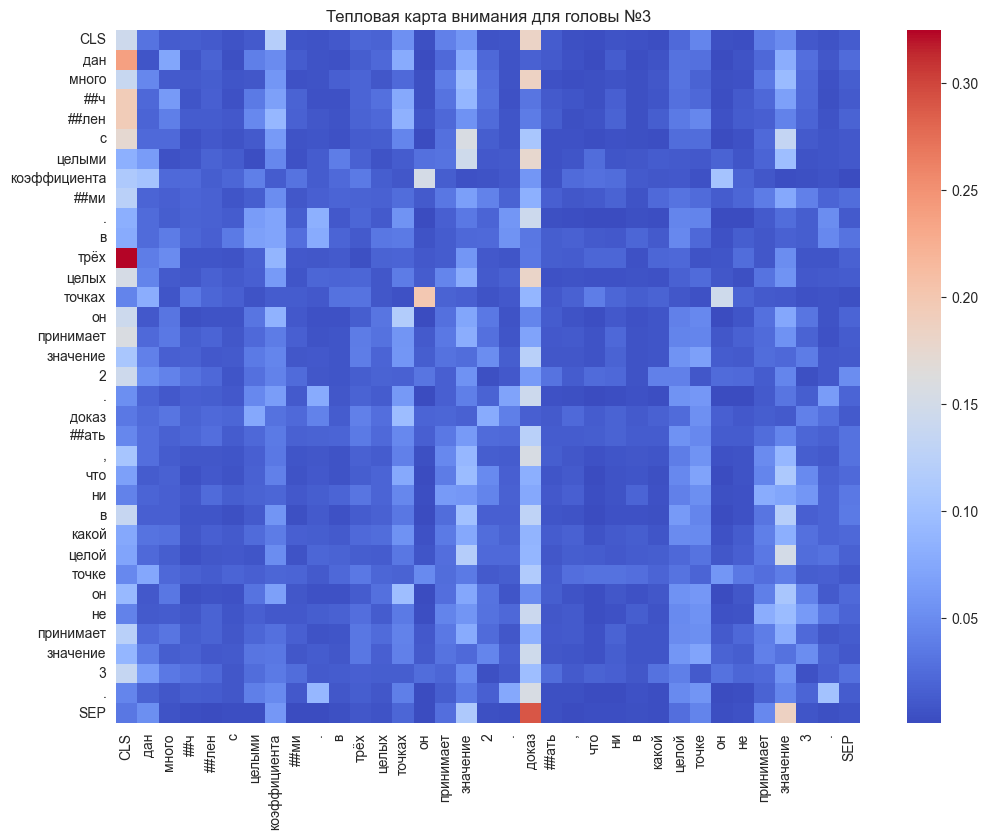

In [29]:
plot_attention_head(sample_2, tokenizer_rubert, rubert_ft_fb, 2)

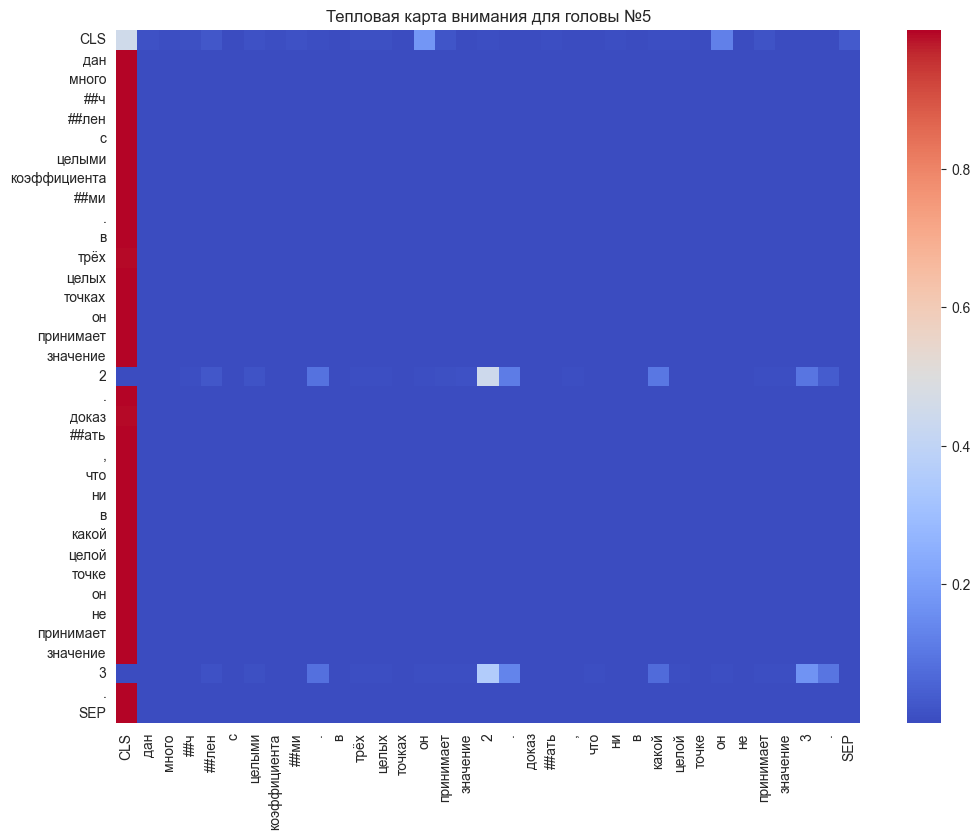

In [30]:
plot_attention_head(sample_2, tokenizer_rubert, rubert_ft_fb, 4)

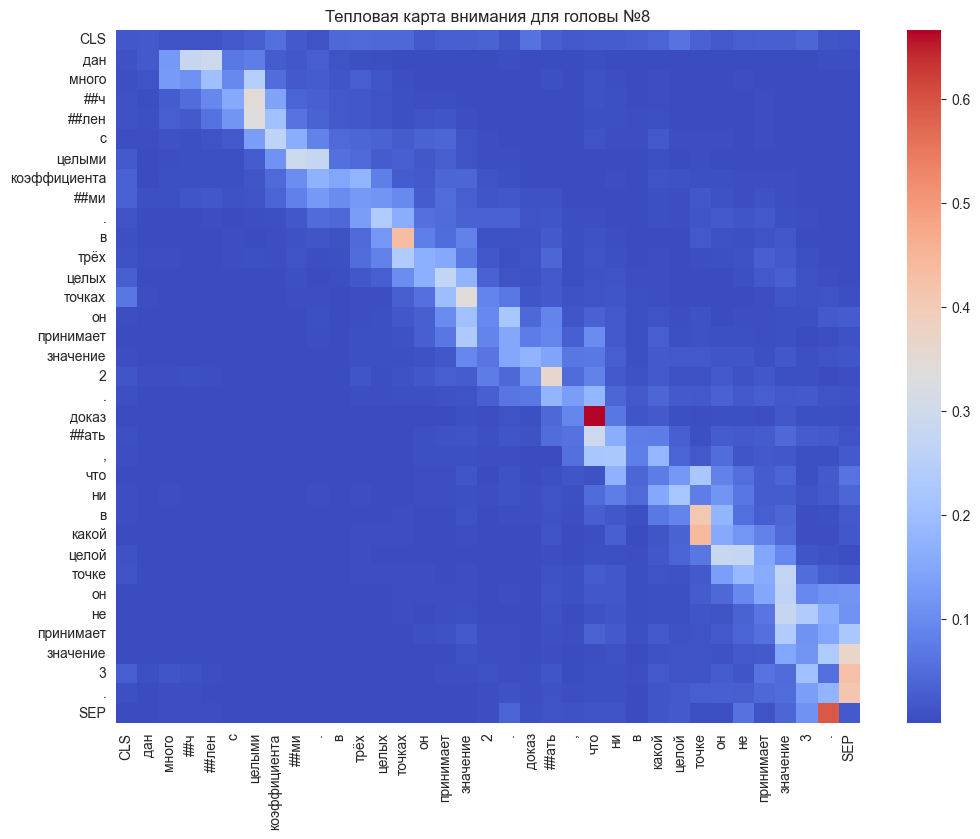

In [31]:
plot_attention_head(sample_2, tokenizer_rubert, rubert_ft_fb, 7)

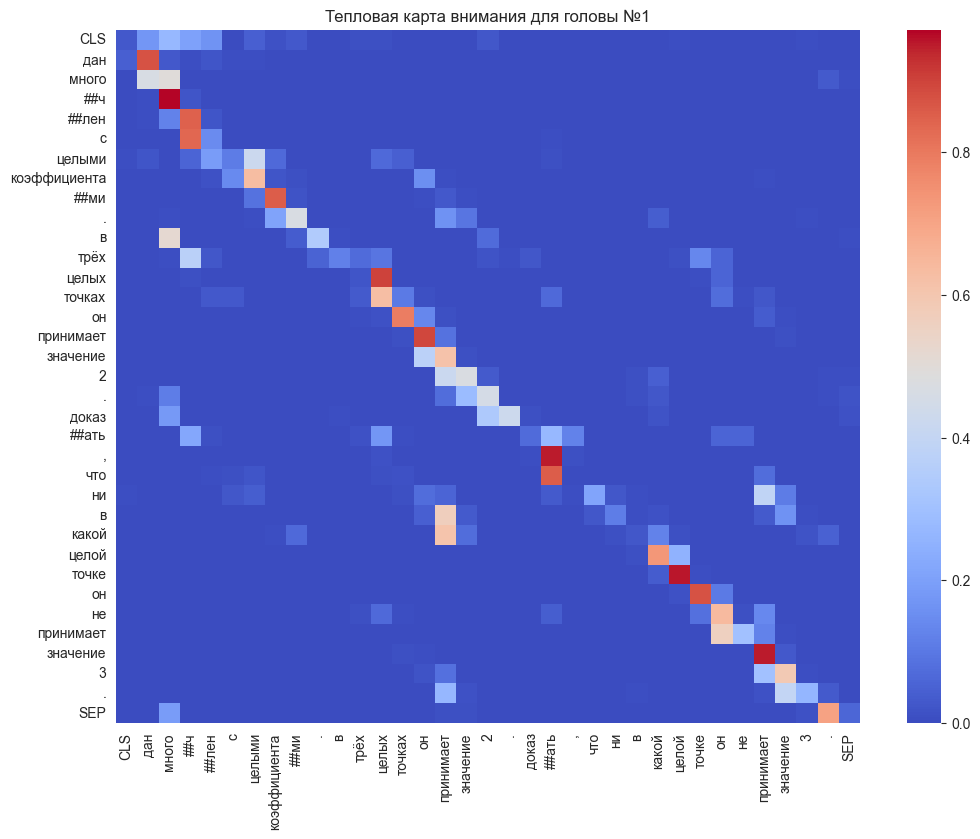

In [32]:
plot_attention_head(sample_2, tokenizer_rubert, rubert_fft, 0)

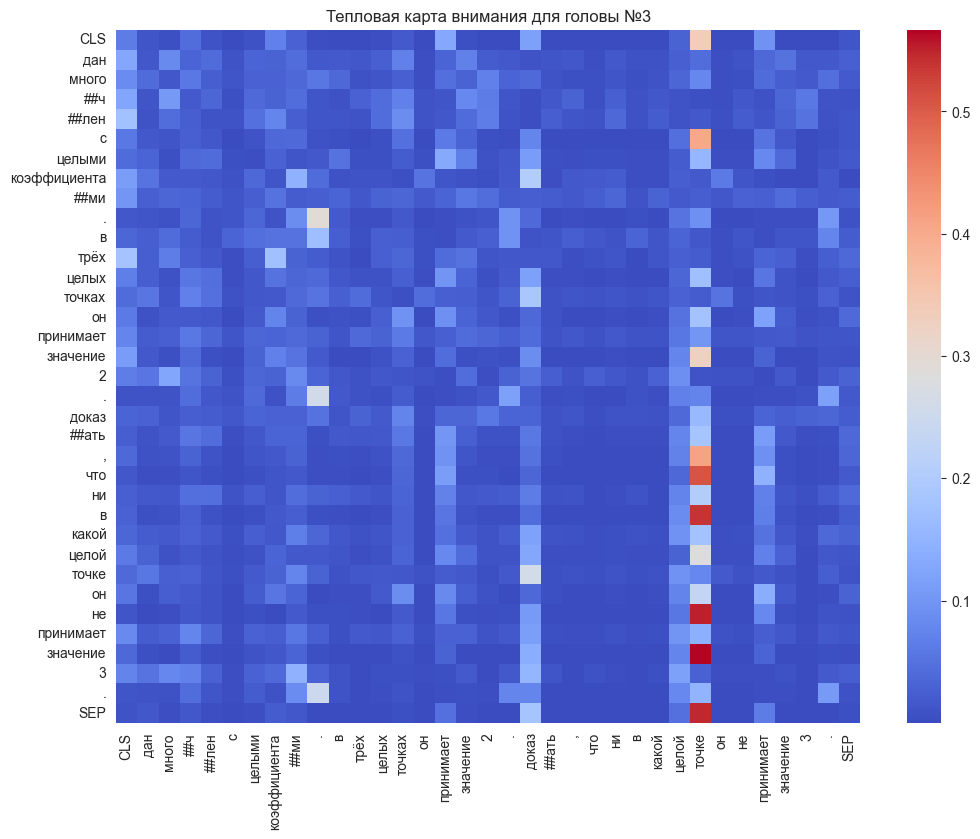

In [33]:
plot_attention_head(sample_2, tokenizer_rubert, rubert_fft, 2)

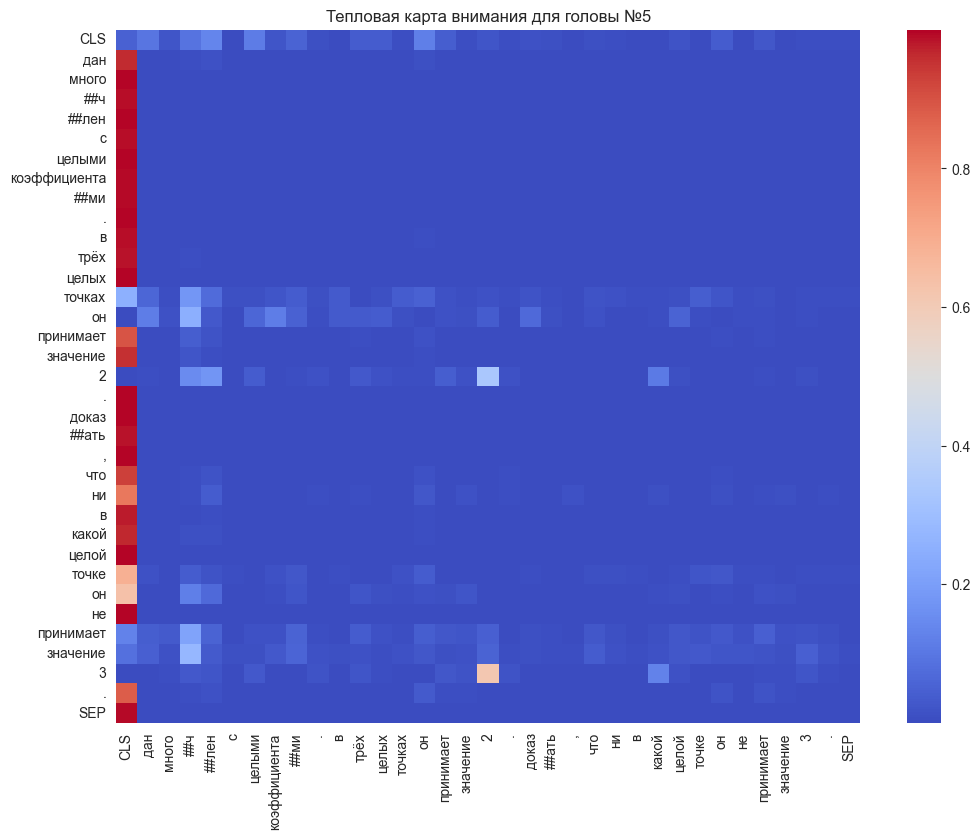

In [34]:
plot_attention_head(sample_2, tokenizer_rubert, rubert_fft, 4)

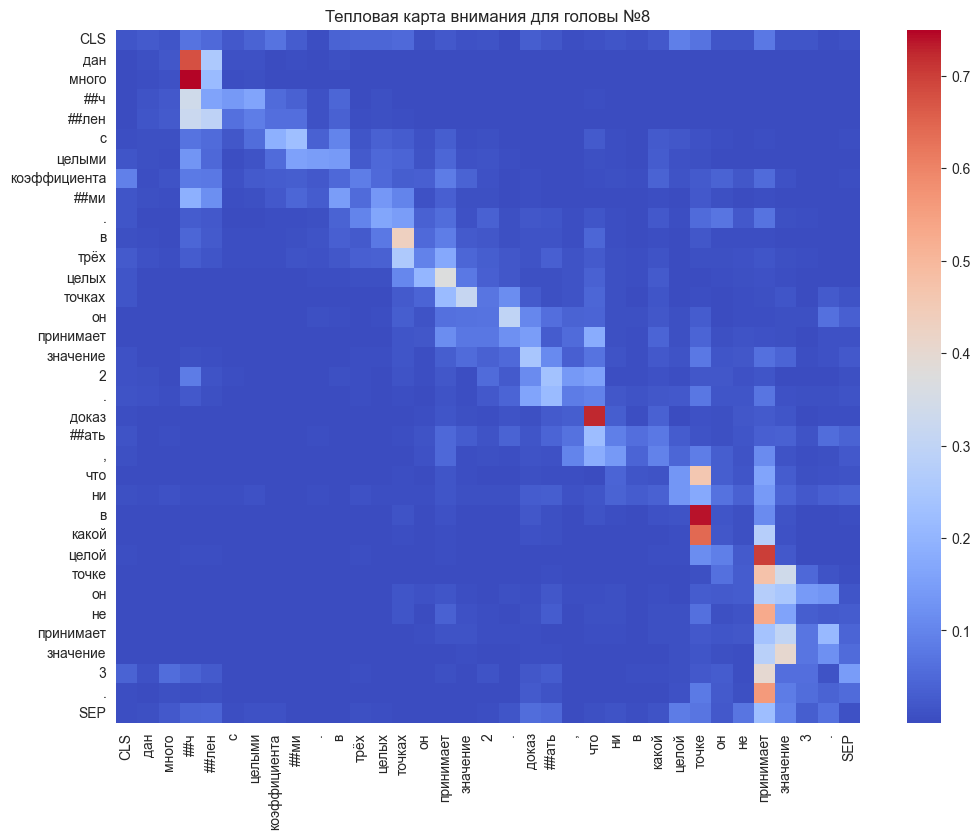

In [35]:
plot_attention_head(sample_2, tokenizer_rubert, rubert_fft, 7)

Для варианта с замороженными слоями в целом результаты очень похожи на не обученную модель и трудно заметить разницу. Вариант с размороженными слоями в свою очередь отличается. Так, голова которая концентрировалась на цифрах теперь пытается связаться и со словами. Попробуем выделить разницу и посмотреть на неё

In [41]:
def plot_diff(sample, tokenizer, model_1, model_2, head_num, Ticks=True):
    inputs = tokenizer(sample["Задача"], return_tensors="pt").to(device)
    tokens = tokenizer.tokenize(sample["Задача"])
    ticks = [t.lower() for t in tokens]
    ticks.append("SEP")
    ticks.insert(0, "CLS")
    with torch.no_grad():
        outputs_1 = model_1(inputs["input_ids"], inputs["attention_mask"], return_attention=True)
        attentions_1 = outputs_1["attentions"][0]
        outputs_2 = model_2(inputs["input_ids"], inputs["attention_mask"], return_attention=True)
        attentions_2 = outputs_2["attentions"][0]
        attentions = torch.abs(attentions_1 - attentions_2)
    fig, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(attentions[0][head_num].cpu().numpy(), cmap="coolwarm")
    ax.set_title(f'Тепловая карта разницы внимания для головы №{head_num+1}')
    if Ticks:
        ax.xaxis.set_ticklabels(ticks, rotation=90)
        ax.yaxis.set_ticklabels(ticks, rotation=0)
    plt.show()


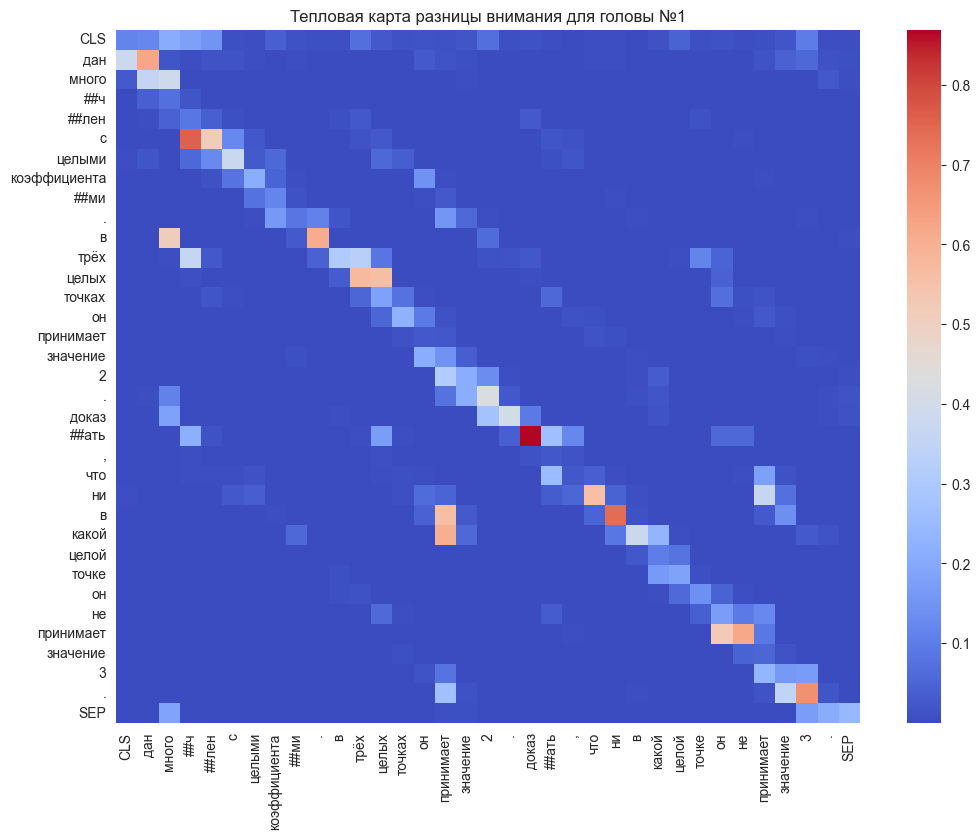

In [42]:
plot_diff(sample_2, tokenizer_rubert, rubert_tiny, rubert_fft, 0)

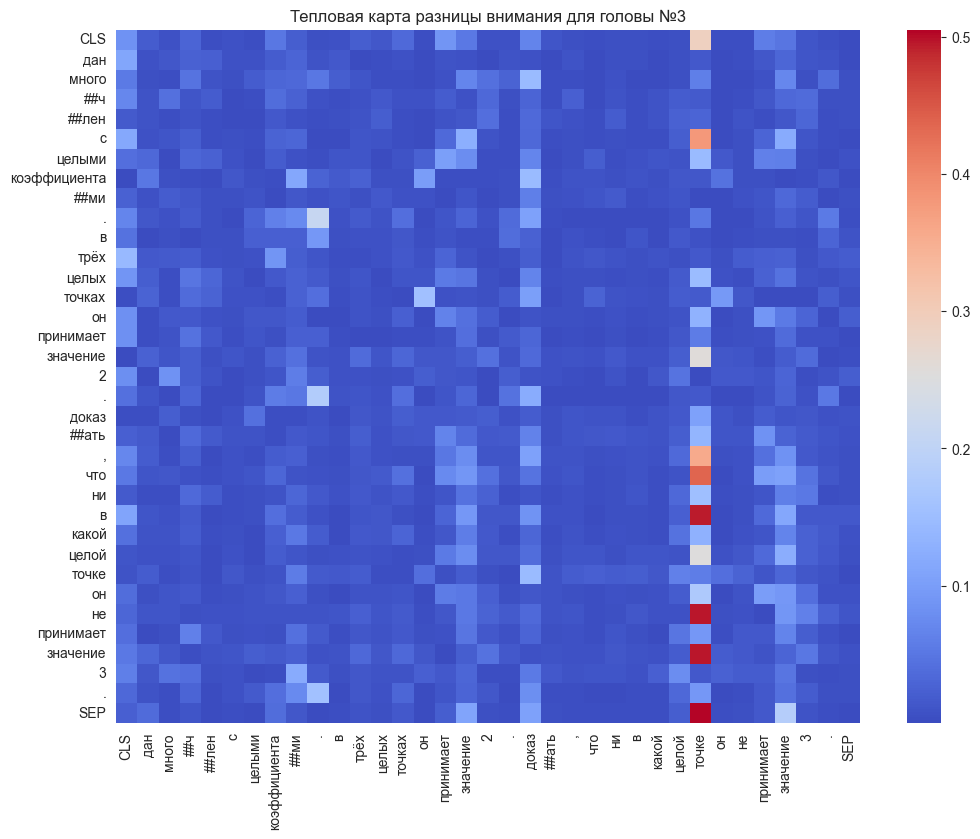

In [43]:
plot_diff(sample_2, tokenizer_rubert, rubert_tiny, rubert_fft, 2)

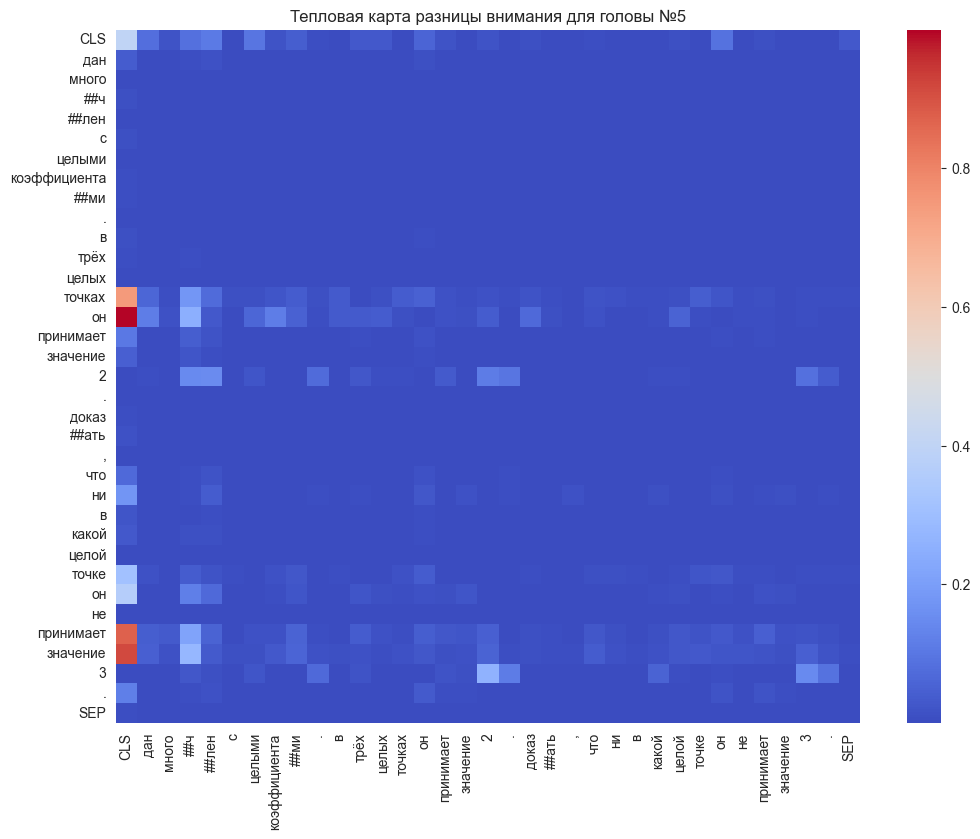

In [44]:
plot_diff(sample_2, tokenizer_rubert, rubert_tiny, rubert_fft, 4)

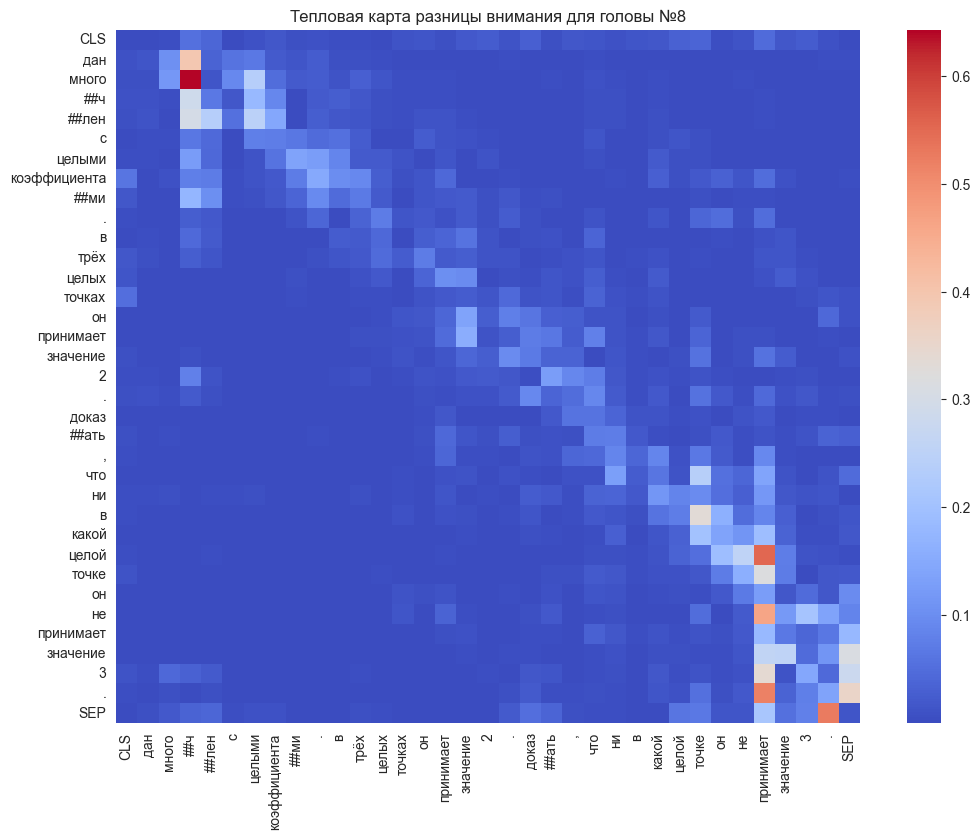

In [45]:
plot_diff(sample_2, tokenizer_rubert, rubert_tiny, rubert_fft, 7)

По результатам сравнения видно, что внимание стало устроено сложнее и разнообразнее после дообучения